In [1]:
import tensorflow as tf
import numpy as np
import t3f
tf.set_random_seed(0)
np.random.seed(0)
%matplotlib inline
import matplotlib.pyplot as plt
import metric_util as mt
import data_util as du
from t3f import shapes
from nilearn import image
from skimage.measure import compare_ssim as ssim
from tensorflow.python.util import nest
import copy
from nilearn import plotting
from t3f import ops
import mri_draw_utils as mrd
from t3f import initializers
from t3f import approximate
from scipy import optimize 
from nilearn.masking import compute_background_mask
from nilearn.masking import compute_epi_mask
from collections import OrderedDict
import pandas as pd
from scipy import stats
from nilearn.image import math_img

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
#sess = tf.InteractiveSession()

In [3]:
def frobenius_norm_tf_squared(x):
    return tf.reduce_sum(x ** 2)

In [4]:
def frobenius_norm_tf(x):
    return tf.reduce_sum(x ** 2) ** 0.5

In [5]:
def relative_error1(x_hat,x_true):
    percent_error = frobenius_norm_tf(x_hat - x_true) / frobenius_norm_tf(x_true)
    return percent_error

In [6]:
def innerProduct(x, y):
    result = tf.reduce_sum(tf.multiply(x, y))
    return result

In [7]:
def compute_step_size(n_omega, grad):
    result = -innerProduct(n_omega,grad)/(innerProduct(n_omega, n_omega))
    return result

In [8]:
def draw(omega, x_true, x_hat, rel_error):
    images_folder = "/work/scratch/tt3"
    ten_ones = np.ones_like(omega)
    x_reconstr1 = mt.reconstruct2(x_hat,ground_truth, omega)
    x_hat_img = mt.reconstruct_image_affine(x_true_org, x_reconstr1)
    x_hat_est = image.index_img(x_hat_img,1)
    
    x_true_org_img = image.index_img(x_true,1)
    x_miss_img = mt.reconstruct_image_affine(x_true_org, x_train)
    x_miss = image.index_img(x_miss_img,1)
    mrd.draw_original_vs_reconstructed_rim(x_true_org_img,x_hat_est, x_miss, "Rim Completion",
                                             rel_error, observed_ratio, coord=None, folder=images_folder)

In [9]:
subject_scan_path = du.get_full_path_subject1()
print "Subject Path: " + str(subject_scan_path)
x_true_org = mt.read_image_abs_path(subject_scan_path)


Subject Path: /work/pl/sch/analysis/data/COBRE001/swaAMAYER+cobre01_63001+M87100944+20110309at135133+RSTpre_V01_R01+CM.nii


In [10]:
def get_mask(data, observed_ratio):
    
    if len(data.shape) == 3:
        mask_indices = (np.random.rand(data.shape[0],data.shape[1],data.shape[2]) < observed_ratio).astype('int') 
    elif len(data.shape) == 4:
        mask_indices = (np.random.rand(data.shape[0],data.shape[1],data.shape[2], data.shape[3]) < observed_ratio).astype('int') 
    elif len(data.shape) == 2:
        mask_indices = (np.random.rand(data.shape[0],data.shape[1]) < observed_ratio).astype('int') 
    
    return mask_indices

In [11]:
def tsc(x_hat,x_true, ten_ones, mask):
    nomin = np.linalg.norm(np.multiply((ten_ones - mask), (x_true - x_hat)))
    denom = np.linalg.norm(np.multiply((ten_ones - mask), x_true))
    score = nomin/denom
    return score 

In [12]:
x_true_img = np.array(x_true_org.get_data())

mask_img = compute_epi_mask(x_true_org)
mask_img_data = np.array(mask_img.get_data())

observed_ratio = 0.8
missing_ratio = 1 - observed_ratio

mask_indices = get_mask(x_true_img, observed_ratio)
epi_mask = copy.deepcopy(mask_img_data)
    
mask_indices[epi_mask==0] = 1



#x_true_img = np.array(x_true_org.get_data())

norm_ground_truth = np.linalg.norm(x_true_img)
x_true_img = x_true_img * (1./norm_ground_truth)

#mask_indices = (np.random.rand(x_true_img.shape[0],x_true_img.shape[1],x_true_img.shape[2], x_true_img.shape[3]) < observed_ratio).astype('int') 
ten_ones = np.ones_like(mask_indices)
ten_zeros = np.zeros_like(x_true_img)
x_train = copy.deepcopy(x_true_img)
x_train[mask_indices==0] = 0.0
#x_train[mask_indices == 0] = np.mean(x_train[mask_indices == 1])
#x_train[mask_indices == 0] = np.mean(x_train[mask_indices == 1])

x_init = copy.deepcopy(x_train)
#shape = (1, 53, 63, 63, 1)
#x_init_tf = t3f.random_tensor(shape, tt_rank=63)


ground_truth = copy.deepcopy(x_true_img)
ground_truth_x = copy.deepcopy(x_true_img)
a_omega = copy.deepcopy(ground_truth)
a_omega[mask_indices==0] = 0.0

sparse_observation = copy.deepcopy(ground_truth)
sparse_observation[mask_indices==0] = 0.0


#x_init1 = np.random.rand(53, 63, 46, 144).astype('float32')
x_init1 = (2*np.random.random_sample(ground_truth.shape) - 1).astype('float32')
#x_init1_img = mt.read_image_abs_path("/work/rs1/init/x_hat_img_95.nii")
#x_init1 = np.array(x_init1_img.get_data()).astype('float32')

norm_ground_x_init1 = np.linalg.norm(x_init1)
x_init_tcs = x_true_img * (1./norm_ground_x_init1)


x_init1 = x_init1 * (1./norm_ground_x_init1)



In [13]:
shape1 = x_init1.shape

In [14]:
print shape1

(53, 63, 46, 144)


In [15]:
norm_ground_truth

74916430.0

In [16]:
xx = list(shape1)

In [17]:
xx1 = xx[0:3]

In [18]:
xx1

[53, 63, 46]

In [19]:
np.max(xx1)

63

In [20]:
std_img = math_img("np.std(img)", img=x_true_org)
mean_img = image.mean_img(x_true_org)
z_scored_image = math_img("(yt - np.mean(yt))/np.std(yt)", yt=x_true_org)
ground_truth_z_score = stats.zscore(z_scored_image.get_data())
mask_z_score_indices = (abs(ground_truth_z_score) > 2).astype('int') 
mask_z_indices_count = np.count_nonzero(mask_z_score_indices==1)
print "mask_z_indices_count: " + str(mask_z_indices_count)

mask_z_indices_count: 687217


In [21]:
folder = '/work/rs1/'

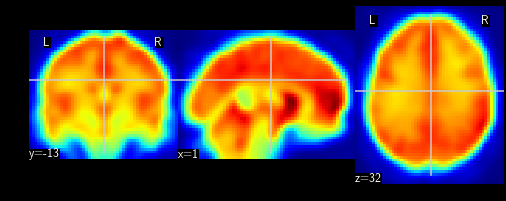

In [22]:
x_org = mt.reconstruct_image_affine(x_true_org, x_true_img)
x_org_img = image.index_img(x_org,1)
#x_true_org_img = image.index_img(x_true_org,1)
org_image = plotting.plot_epi(x_org_img, bg_img=None,black_bg=True, cmap='jet', cut_coords=None)

In [23]:
ten_ones = np.ones_like(mask_indices)


In [24]:
x_reconstr_init = mt.reconstruct2(x_init_tcs,ground_truth, mask_indices)

In [25]:
tsc_score_init = tsc(x_reconstr_init,ground_truth, ten_ones, mask_indices).astype('float32')

In [26]:
print tsc_score_init

0.9996317


In [27]:
norm_sparse_observation = np.linalg.norm(sparse_observation)
print norm_sparse_observation

0.9044032


In [28]:
denom_tsc = np.linalg.norm((1.0 - mask_indices) * x_true_img)

In [29]:
print denom_tsc

0.4267951503964641


In [30]:
mask_indices_tf = t3f.to_tt_tensor(mask_indices.astype('float32'), max_tt_rank=63)

[1, 53, 1, 1, 1] 0 (1, 53, 53)
[1, 53, 63, 1, 1] 1 (53, 63, 63)
[1, 53, 63, 63, 1] 2 (63, 46, 63)
ranks: [1, 53, 63, 63, 1]


In [31]:
#x_miss_img = mt.reconstruct_image_affine(x_true_org, x_train*norm_ground_truth)
x_miss_img = mt.reconstruct_image_affine(x_true_org, x_train)

In [32]:
x_miss = norm_ground_truth*x_train

In [33]:
x_miss = image.index_img(x_miss_img,1)

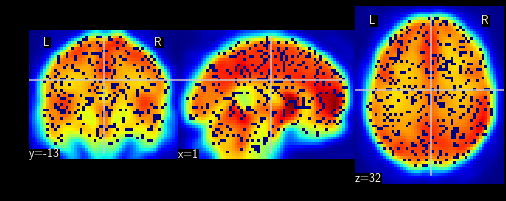

In [34]:
x_miss_image = plotting.plot_epi(x_miss, bg_img=None,black_bg=True, cmap='jet', cut_coords=[1, -13, 32]) 

In [35]:
images_folder = "/work/scratch/tt3"
mrd.draw_original_vs_reconstructed_rim(image.index_img(x_true_org,1),image.index_img(x_miss_img,1), image.index_img(x_miss_img,1), "Rim Completion",
                                             observed_ratio, observed_ratio, coord=None, folder=images_folder)

('Saving figure', '/work/scratch/tt3/missing_ratio_20.00.png')
Called from mrd


In [36]:
import nibabel as nib
import os

suffix = int(round((missing_ratio)*100.0, 0))
print "Missing Ratio: " + str(missing_ratio)
x_true_path = os.path.join(folder,"x_true_img_" + str(suffix))
x_miss_path = os.path.join(folder,"x_miss_img_" + str(suffix))
        
print("x_true_path:" + str(x_true_path))
nib.save(x_true_org, x_true_path)
nib.save(x_miss_img, x_miss_path)

Missing Ratio: 0.2
x_true_path:/work/rs1/x_true_img_20


In [37]:
ground_truth_tf = t3f.to_tt_tensor(ground_truth, max_tt_rank=63)

[1, 53, 1, 1, 1] 0 (1, 53, 53)
[1, 53, 63, 1, 1] 1 (53, 63, 63)
[1, 53, 63, 63, 1] 2 (63, 46, 63)
ranks: [1, 53, 63, 63, 1]


In [38]:
A = t3f.get_variable('A', initializer=ground_truth_tf, trainable=False)

In [39]:
ground_truth = tf.get_variable('ground_truth', initializer=ground_truth, trainable=False)
sparsity_mask = tf.get_variable('sparsity_mask', initializer=mask_indices, trainable=False)
sparsity_mask = tf.cast(sparsity_mask,tf.float32)
sparse_observation = ground_truth * sparsity_mask

In [40]:
#sparsity_mask = t3f.get_variable('sparsity_mask', initializer=mask_indices_tf, trainable=False)
#sparsity_mask = t3f.cast(sparsity_mask, tf.float32)
#sparse_observation_tf = t3f.to_tt_tensor(sparse_observation, max_tt_rank=63)
#sparse_observation_tf3 = t3f.get_variable('sparse_observation_tf', initializer=sparse_observation_tf, trainable=False)

In [41]:
shape  =  (53, 63, 46, 144)

In [42]:
x_train_tf = t3f.to_tt_tensor(x_init1, max_tt_rank=63)

[1, 53, 1, 1, 1] 0 (1, 53, 53)
[1, 53, 63, 1, 1] 1 (53, 63, 63)
[1, 53, 63, 63, 1] 2 (63, 46, 63)
ranks: [1, 53, 63, 63, 1]


In [43]:
#x_train_tf = t3f.random_tensor(shape, tt_rank=63)

In [44]:
normAOmegavar = tf.get_variable('normAOmega', initializer=norm_sparse_observation, trainable=False)

In [45]:
X = t3f.get_variable('X', initializer=x_train_tf)

In [46]:
X_new = t3f.get_variable('X_new', initializer=x_train_tf)

In [47]:
tf_zeros = tf.get_variable('tf_zeros', initializer=ten_zeros, trainable=False)
tf_zeros = tf.cast(tf_zeros,tf.float32)

In [48]:
L = t3f.get_variable('L', initializer=ground_truth_tf)
Lnew = t3f.get_variable('Lnew', initializer=ground_truth_tf)
S = tf.get_variable('S', initializer=tf_zeros)
G = tf.get_variable('G', initializer=tf_zeros)

In [49]:
print X

A Tensor Train variable of shape (53, 63, 46, 144), TT-ranks: (1, 53, 63, 63, 1)


In [50]:
def train_it_rel_cost(cost_hist, k):
    res = np.abs(cost_hist[k] - cost_hist[k-1])/np.abs(cost_hist[k])
    return res

In [51]:
counter = tf.get_variable('counter', initializer=0)

In [52]:
one = tf.constant(1)
zero_point1 = tf.constant(0.1)

In [53]:
tf_ones = tf.get_variable('tf_ones', initializer=ten_ones, trainable=False)
tf_ones = tf.cast(tf_ones,tf.float32)


In [54]:
print tf_ones

Tensor("Cast_2:0", shape=(53, 63, 46, 144), dtype=float32)


In [55]:
tt_zeros = initializers.tensor_zeros([53, 63, 46, 144])

In [56]:
denom_tsc_tf = tf.get_variable('denom_tsc_tf', initializer=denom_tsc, trainable=False)
denom_tsc_tf = tf.cast(denom_tsc_tf,tf.float32)

In [57]:
#eta_t3f_old = t3f.get_variable('eta_t3f_old', initializer=tt_zeros)
#grad_t3f_old = t3f.get_variable('grad_t3f_old', initializer=tt_zeros)

In [58]:
eta_old = tf.get_variable('eta_old', shape = (53, 63, 46, 144), validate_shape=False)
grad_old = tf.get_variable('grad_old', shape = (53, 63, 46, 144), validate_shape=False)

In [59]:
one = tf.constant(1)
zero_point1 = tf.constant(0.1)

In [60]:


def gradient(x):
    return np.multiply(x,mask_indices) - a_omega
    
def cost_func(x):
    return 0.5*(np.linalg.norm(np.multiply(x,mask_indices)-a_omega)** 2)

def find_step_size(x,g,d, old_cost):
    step_size = optimize.line_search(cost_func,gradient,x,d,gfk=None, old_fval=old_cost)

In [61]:
# Algorithm
#grad_full = (t3f.full(X)*t3f.full(sparse_observation_tf3) - t3f.full(sparse_observation_tf3))
#counter_step = tf.assign(counter, counter + 1)

#grad_trans = t3f.riemannian.project(grad_t3f_old, X)
#eta_trans = t3f.riemannian.project(eta_t3f_old, X)
    
#grad_full = sparsity_mask * t3f.full(X) - sparse_observation
#grad_t3f = t3f.to_tt_tensor(grad_full, max_tt_rank=63)

#loss = 0.5 * t3f.frobenius_norm_squared(grad_t3f)
#gradnorm_omega = t3f.frobenius_norm(grad_t3f)/(normAOmegavar)

#riemannian_grad = t3f.riemannian.project(grad_t3f, X)


#eta_omega = sparsity_mask * t3f.full(-riemannian_grad)
#alpha = compute_step_size(eta_omega, grad_full)



#riemannian_grad_norm = t3f.flat_inner(riemannian_grad, riemannian_grad)



#rel_error1 = relative_error1(t3f.full(X), t3f.full(sparse_observation))




In [62]:
eps = 1e-15
epsilon_train=1e-15

In [63]:
#print grad_full

In [64]:
#print grad_t3f

In [65]:
print eps

1e-15


In [66]:
#alpha = 0.3


In [67]:
def cost_with_treshold(x, thresh = 0.03):
    res = tf.abs(x)
    zeros = tf.zeros_like(x)
    masked = tf.greater(res, thresh)
    new_tensor = tf.where(masked, x, zeros)
    return new_tensor

In [68]:
def compute_loss(x, x_true):
    return frobenius_norm_tf_squared(x_true - cost_with_treshold(x_true - t3f.full(x)))

In [69]:
def reconstruct_tf(x_hat):
    x_reconstruct = sparse_observation + (tf_ones - sparsity_mask)*x_hat
    return x_reconstruct

In [70]:
def tsc_tf(x_hat,x_true_omega, mask):
    x_rec = reconstruct_tf(x_hat)
    nomin = frobenius_norm_tf((tf_ones - sparsity_mask)*(x_rec - sparse_observation))
    #denom = frobenius_norm_tf(tf.multiply(tf_ones - sparsity_mask),(sparse_observation))
    score = nomin/denom_tsc_tf
    return score  


In [71]:
#first step

In [72]:
zero_point1 = tf.constant(0.1)
backtack_const = tf.constant(1e-4)

initial_cost = compute_loss(L, ground_truth)
cost = tf.get_variable('cost', initializer=initial_cost)
cost_new = tf.get_variable('cost_new', initializer=0.0)

#tsc_score_curr = tsc_tf(t3f.full(X),ground_truth, sparse_observation)
completion_score = tf.get_variable('completion_score', initializer=tsc_score_init, dtype = tf.float32)

grad_full_0 = ground_truth - cost_with_treshold(ground_truth - t3f.full(L))
grad_t3f_0 = t3f.to_tt_tensor(grad_full_0, max_tt_rank=63)
gradnorm_omega_0 = t3f.frobenius_norm(grad_t3f_0)/(frobenius_norm_tf(ground_truth))

riemannian_grad_0 = t3f.riemannian.project(grad_t3f_0, L)
riemannian_grad_0 = t3f.round(riemannian_grad_0, max_tt_rank =63, epsilon = 1e-15)

grad_t3f_old = t3f.get_variable('grad_t3f_old', initializer=riemannian_grad_0)

#grad_t3f_old_op = t3f.assign(grad_t3f_old, riemannian_grad_0, validate_shape=False)
riemannian_grad_full_0 = t3f.full(riemannian_grad_0)
riemannian_grad_init_op = tf.assign(grad_old,riemannian_grad_full_0)

eta_t3f_0 = -riemannian_grad_0
eta_t3f_old = t3f.get_variable('eta_t3f_old', initializer=eta_t3f_0)

eta_0 = -riemannian_grad_init_op
eta_omega_0 = sparsity_mask * t3f.full(-riemannian_grad_0)

alpha_0 = compute_step_size(eta_omega_0, riemannian_grad_init_op)
eta_op_0 = tf.assign(eta_old,eta_0, validate_shape=False)

eta_norm = tf.get_variable('eta_norm', initializer=0.0)
eta_norm_init_op = tf.assign(eta_norm, frobenius_norm_tf(eta_op_0))

alpha_old = tf.get_variable('alpha_old', initializer=0.0)

train_step_0 = t3f.assign(L, t3f.round(L - alpha_0 * eta_t3f_0, max_tt_rank=63))
train_step_s0 = tf.assign(S, cost_with_treshold(ground_truth - t3f.full(train_step_0)))



[1, 53, 1, 1, 1] 0 (1, 53, 53)
[1, 53, 63, 1, 1] 1 (53, 63, 63)
[1, 53, 63, 63, 1] 2 (63, 46, 63)
ranks: [1, 53, 63, 63, 1]
Max_TT rank63
[1, 53, 63, 63, 1]
Max_TT rank63
[1, 53, 63, 63, 1]


In [73]:
print "Rim 0:" + str(riemannian_grad_0)

Rim 0:A Tensor Train of shape (53, 63, 46, 144), TT-ranks: (1, 53, 63, 63, 1)


In [74]:
print "Eta 0: " + str(eta_t3f_0)

Eta 0: A Tensor Train of shape (53, 63, 46, 144), TT-ranks: (1, 53, 63, 63, 1)


In [75]:
#tt = t3f.round(eta_t3f_old, max_tt_rank =63, epsilon = 1e-15

In [76]:
# new
#t3f.assign(eta_t3f_old, t3f.round(eta_t3f_old, max_tt_rank =63, epsilon = 1e-15))


In [77]:
counter_step = tf.assign(counter, counter + 1)

grad_trans = t3f.riemannian.project(grad_t3f_old, L)
eta_trans = t3f.riemannian.project(eta_t3f_old, L)
    
grad_full = ground_truth - cost_with_treshold(ground_truth - t3f.full(L))
grad_t3f = t3f.to_tt_tensor(grad_full, max_tt_rank=63)

loss = t3f.frobenius_norm_squared(grad_t3f)
gradnorm_omega = t3f.frobenius_norm(grad_t3f)/(frobenius_norm_tf(ground_truth))

riemannian_grad =  t3f.round(t3f.riemannian.project(grad_t3f, L),max_tt_rank =63)
#riemannian_grad = t3f.round(riemannian_grad, max_tt_rank =63, epsilon = 1e-15)
riemannian_grad_norm = t3f.frobenius_norm(riemannian_grad)

inner_product_rim_grad = t3f.flat_inner(riemannian_grad, riemannian_grad)
ip_xitrans_xi = t3f.flat_inner(grad_trans,riemannian_grad)
theta = ip_xitrans_xi / inner_product_rim_grad

def get_theta():
    return t3f.full(ip_xitrans_xi / inner_product_rim_grad)

def get_value_zero_point1():
    return zero_point1
    
def get_conj_dir():
    print "conjugate gradient"
    tf.Print(zero_point1,[zero_point1],message="conjugate gradient")
    return t3f.full(approximate.add_n([-riemannian_grad, beta*eta_trans], max_tt_rank=63))

def get_rim_grad():
    print "steepest descent"
    tf.Print(zero_point1,[zero_point1],message="steepest descent")
    return t3f.full(-riemannian_grad)

# compute beta
inner_product_rim_grad_old = t3f.flat_inner(grad_t3f_old, grad_t3f_old)
beta = tf.maximum(0.0, (inner_product_rim_grad - ip_xitrans_xi)/inner_product_rim_grad_old)
#eta = -riemannian_grad + beta*eta_trans

print "Rim Grad shape: " + str(riemannian_grad)
print "eta_trans: " + str(eta_trans)

eta_cond = tf.cond((tf.abs(theta) >= zero_point1), get_rim_grad, get_conj_dir)
eta_norm_update_op = tf.assign(eta_norm, frobenius_norm_tf(eta_cond))

#eta = tf.case([(tf.greater_equal(theta_full,zero_point1), get_rim_grad)], default=get_conj_dir, exclusive=True)
#eta = approximate.add_n([-riemannian_grad, beta*eta_trans], max_tt_rank=63)
eta = t3f.to_tt_tensor(eta_cond, max_tt_rank=63)

inprod_grad_eta = t3f.flat_inner(riemannian_grad,eta)
#
#eta_full = t3f.full(eta)

print "eta: " + str(eta)
#print "eta1: " + str(eta1)
                                            
#(1, 106, 126, 126, 1)

eta_omega = sparsity_mask * t3f.full(eta)
alpha = compute_step_size(eta_omega, grad_full)

#two = tf.constant(2.0)
#alpha1 =tf.maximum(0.0,two*(cost_new - cost)/inprod_grad_eta)

[1, 53, 1, 1, 1] 0 (1, 53, 53)
[1, 53, 63, 1, 1] 1 (53, 63, 63)
[1, 53, 63, 63, 1] 2 (63, 46, 63)
ranks: [1, 53, 63, 63, 1]
Max_TT rank63
[1, 53, 63, 63, 1]
Rim Grad shape: A Tensor Train of shape (53, 63, 46, 144), TT-ranks: (1, 53, 63, 63, 1)
eta_trans: A Tensor Train of shape (53, 63, 46, 144), TT-ranks: (1, 106, 126, 126, 1)
steepest descent
conjugate gradient
Max_TT rank63
[1, 53, 63, 63, 1]
[1, 53, 1, 1, 1] 0 (1, 53, 53)
[1, 53, 63, 1, 1] 1 (53, 63, 63)
[1, 53, 63, 63, 1] 2 (63, 46, 63)
ranks: [1, 53, 63, 63, 1]
eta: A Tensor Train of shape (53, 63, 46, 144), TT-ranks: (1, 53, 63, 63, 1)


In [78]:
#eta1 = tf.cond((theta > zero_point1), get_rim_grad, get_conj_dir)

In [79]:
print eta

A Tensor Train of shape (53, 63, 46, 144), TT-ranks: (1, 53, 63, 63, 1)


In [80]:
#cost_old_update = compute_loss(X)
#cost_old_op = tf.assign(cost_old,cost_old_update)

In [81]:
train_new_step = t3f.assign(Lnew, t3f.round(L + alpha * eta, max_tt_rank=63))

Max_TT rank63
[1, 53, 63, 63, 1]


In [82]:
updated_cost_new = compute_loss(train_new_step, ground_truth)
cost_new_op = tf.assign(cost_new,updated_cost_new)

In [83]:
train_step = t3f.assign(L, t3f.round(L + alpha * eta, max_tt_rank=63))

Max_TT rank63
[1, 53, 63, 63, 1]


In [84]:
train_step_s = tf.assign(S, cost_with_treshold(ground_truth - t3f.full(train_step)))

In [85]:
updated_cost = compute_loss(train_step, ground_truth)
cost_op = tf.assign(cost,updated_cost)

In [86]:
eta_update_op = t3f.assign(eta_t3f_old, eta,use_locking = True)

In [87]:
grad_update_op = t3f.assign(grad_t3f_old, riemannian_grad)

In [88]:
print alpha_0

Tensor("div_1:0", shape=(), dtype=float32)


In [89]:
print theta

Tensor("div_3:0", shape=(), dtype=float32)


In [90]:
print zero_point1

Tensor("Const_7:0", shape=(), dtype=float32)


In [91]:
tsc_score_history = []

In [92]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [93]:
log = []
train_loss_hist = []
#for i in range(1000):
gradnorm_val, alpha_val, eta_op_0_val,cost_val, cost_new_val, eta_norm_val,_,_ = sess.run([gradnorm_omega_0, alpha_0, eta_op_0, cost, cost_new, eta_norm,train_step_0.op, eta_norm_init_op.op])
print gradnorm_val, alpha_val,cost_val, cost_new_val, eta_norm_val

1.0001159 1.0 1.0001111 0.0 1.0000606


In [94]:
print grad_trans

A Tensor Train of shape (53, 63, 46, 144), TT-ranks: (1, 106, 126, 126, 1)


In [95]:
def loss_func(x, y):
    return 0.5*(np.linalg.norm(x - y)** 2)
    

In [96]:
def is_nan(x):
    return (x is np.nan or x != x)

In [97]:
backtrack_const = 1e-4 

In [98]:
cost_history = []


In [99]:
#sess.run([loss, gradnorm_omega, alpha, theta, eta_update_op, grad_update_op, train_step.op])

In [100]:



i = 0
cost_nan = False
while gradnorm_val > eps:   
#for k in range(10):
    i = i + 1
    #F_v, gradnorm_val, alpha_val,theta_val, beta_val, cost_new_val, cost_val,tsc_score_val, eta_norm_val, inprod_grad_eta_val, riemannian_grad_norm_val,_, _,_,_,_,_ = sess.run([loss, gradnorm_omega, alpha, theta, beta, cost_new, cost, completion_score, eta_norm, inprod_grad_eta, riemannian_grad_norm,eta_norm_update_op.op, cost_new_op.op, train_new_step.op, tsc_score_op.op, eta_update_op.op, grad_update_op.op])
    #tsc_score_update_op
    #eta_old_val, grad_update_val,_ = sess.run([eta_update_op, grad_update_op])
    F_v, gradnorm_val, alpha_val,theta_val, beta_val, cost_new_val, cost_val,eta_norm_val, inprod_grad_eta_val, riemannian_grad_norm_val,_, _,_,_,_ = sess.run([loss, gradnorm_omega, alpha, theta, beta, cost_new, cost, eta_norm, inprod_grad_eta, riemannian_grad_norm,eta_norm_update_op.op, cost_new_op.op, train_new_step.op, eta_update_op.op, grad_update_op.op])
    
    print "alpha_val: " + str(alpha_val)
    print "theta_val: " + str(theta_val)
    print "inprod_grad_eta_val: " + str(inprod_grad_eta_val)
    print "rim_grad_norm: " + str(riemannian_grad_norm_val)
    print "eta_norm_val: " + str(eta_norm_val)
    
    lr = alpha_val
    cost_prev_value = cost_val
    cost_new_value = cost_new_val
    cost_0 = cost_val
    
    print "Cost New: " +str(cost_new_value)
    print "Cost Old: " +str(cost_prev_value)
        
          
    backtrackiter = 0

    max_iter_count = 10
    #armijo = (cost_new_val <= cost_prev_value + backtrack_const*(lr)*inprod_grad_eta_val)
    armijo = (cost_new_val <= cost_prev_value + backtrack_const*(lr)*inprod_grad_eta_val)
    print "armijo: " + str(armijo)
    
    proposed_initial_alpha = 2*(cost_new_value - cost_prev_value)/inprod_grad_eta_val
    print "proposed_initial_alpha: " + str(proposed_initial_alpha)
    
    #diff_train = np.abs(train_loss_hist[i - 1] - train_loss_hist[i-2])
    
    #while (cost_prev - cost_new) <= -backtrack_const*(-lr)*inprod_grad_eta_val:
    #while (not (cost_new <= cost_prev + backtrack_const*(lr)*inprod_grad_eta_val)):
    while ((cost_new_value > cost_prev_value + backtrack_const*(lr)*inprod_grad_eta_val)):
    #while ((tsc_score_new > tsc_score_old) or (cost_new_value > cost_prev_value + backtrack_const*(lr)*inprod_grad_eta_val)):
        
        print "Backtracking"
        lr = 0.5*lr
        print "Learning Rate: " + str(lr)
        sess.run(t3f.assign(Lnew, t3f.round(L + lr * eta_t3f_old, max_tt_rank=63)).op)
        x_new_val = sess.run(t3f.full(Lnew))
        x_new_val[mask_indices==0] = 0.0
        
               
        print "proposed_initial_alpha: " + str(proposed_initial_alpha)
        proposed_step_size = proposed_initial_alpha /inprod_grad_eta_val
        print "proposed_step_size: " + str(proposed_step_size)
        proposed_initial_alpha = 0.5* proposed_step_size
        
        cost_new_value = loss_func(x_new_val, a_omega)
        sess.run(tf.assign(cost_new,cost_new_value).op)
        
        if is_nan(cost_new):
            cost_nan = True
            break
        
        print "Cost New: " +str(cost_new_value)
        print "Cost Old: " +str(cost_prev_value)
        backtrackiter = backtrackiter + 1
        print "backtrackiter_count: " + str(backtrackiter)
    
        if cost_nan:
            print "Cost is Nan. Breaking after " + str(i) + "; iterations"
            break
        
        if backtrackiter>= max_iter_count:
           print "Breaking after " + str(i) + "; iterations"
           break
    
    
    if (cost_new_value < cost_prev_value):
    #if (cost_new_value < cost_prev_value or (tsc_score_new <= tsc_score_old)):
        # update x
        print "updating X: initial cost: " + str(cost_prev_value) + "; New Cost: " +  str(cost_new_value)
        sess.run([t3f.assign(L, Lnew).op, tf.assign(cost,cost_new_value).op])
    else:
        print "Reject Step: not updating X: initial cost: " + str(cost_prev_value) + "; New Cost: " +  str(cost_new_value)
              
    train_loss_hist.append(gradnorm_val)
    cost_history.append(cost_new_value)
    
    if i > 1:
        diff_train = np.abs(train_loss_hist[i - 1] - train_loss_hist[i-2])/np.abs(train_loss_hist[i-1])
        print (F_v, i, gradnorm_val, diff_train, alpha_val, theta_val, beta_val, cost_val, cost_new_val)
        if diff_train <= epsilon_train:
            print "Breaking after " + str(i) + " iterations. Training Error Diffrence less than train_epsilon"
            break
    else:
        print (F_v, i, gradnorm_val, alpha_val, theta_val, beta_val, cost_val, cost_new_val)
    log.append(F_v)

alpha_val: 0.9999973
theta_val: 1.000007
inprod_grad_eta_val: -1.0003424
rim_grad_norm: 1.0001731
eta_norm_val: 1.0000539
Cost New: 1.0001111
Cost Old: 1.0001111
armijo: False
proposed_initial_alpha: -0.0
Backtracking
Learning Rate: 0.49999865889549255
Max_TT rank63
[1, 53, 63, 63, 1]
proposed_initial_alpha: -0.0
proposed_step_size: 0.0
Cost New: 0.10225698670752736
Cost Old: 1.0001111
backtrackiter_count: 1
updating X: initial cost: 1.0001111; New Cost: 0.10225698670752736
(1.0003328, 1, 1.0001159, 0.9999973, 1.000007, 0.0, 1.0001111, 1.0001111)
alpha_val: 0.99999607
theta_val: 0.9999995
inprod_grad_eta_val: -1.0003451
rim_grad_norm: 1.0001746
eta_norm_val: 1.0000556
Cost New: 1.0001111
Cost Old: 0.10225698
armijo: False
proposed_initial_alpha: -1.7950886748178485
Backtracking
Learning Rate: 0.4999980330467224
Max_TT rank63
[1, 53, 63, 63, 1]
proposed_initial_alpha: -1.7950886748178485
proposed_step_size: 1.7944693838858667
Cost New: 4.0965033416644734e-06
Cost Old: 0.10225698
backtra

In [101]:
print beta

Tensor("Maximum:0", shape=(), dtype=float32)


In [102]:
#sess.run([eta_update_op.op, grad_update_op.op])

In [103]:
print X

A Tensor Train variable of shape (53, 63, 46, 144), TT-ranks: (1, 53, 63, 63, 1)


In [104]:
estimated_val = sess.run(t3f.full(L))

In [105]:
ground_truth_val = sess.run(ground_truth)


In [106]:
x_reconstr = estimated_val


In [107]:
def relative_error(x_hat,x_true):
    percent_error = np.linalg.norm(x_hat - x_true) / np.linalg.norm(x_true)
    return percent_error

In [108]:
rel_error = relative_error(estimated_val,ground_truth_val)

In [109]:
print rel_error

0.0029983828


In [110]:
rel_error_rec = relative_error(x_reconstr,ground_truth_val)

In [111]:
rel_error_rec

0.0029983828

In [112]:
x_miss_img = mt.reconstruct_image_affine(x_true_org, x_train)

In [113]:
x_miss = image.index_img(x_miss_img,1)

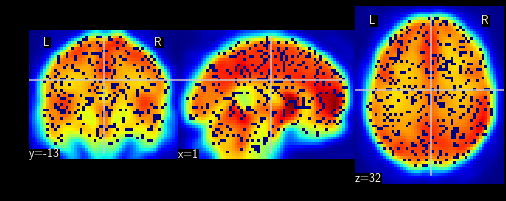

In [114]:
x_miss_image = plotting.plot_epi(x_miss, bg_img=None,black_bg=True, cmap='jet', cut_coords=[1, -13, 32]) 

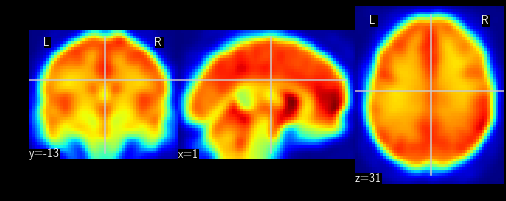

In [115]:
x_hat_img = mt.reconstruct_image_affine(x_true_org, x_reconstr)
x_hat = image.index_img(x_hat_img,1)
recovered_image = plotting.plot_epi(x_hat, bg_img=None,black_bg=True, cmap='jet', cut_coords=None)

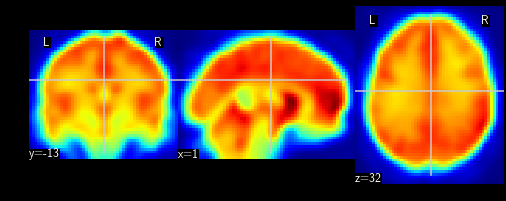

In [116]:
x_org = mt.reconstruct_image_affine(x_true_org, x_true_img)
x_org_img = image.index_img(x_org,1)
#x_true_org_img = image.index_img(x_true_org,1)
org_image = plotting.plot_epi(x_org_img, bg_img=None,black_bg=True, cmap='jet', cut_coords=None)

In [117]:
#x_true_org_img = image.index_img(x_true_org,1)
#org_image = plotting.plot_epi(x_true_org_img, bg_img=None,black_bg=True, cmap='jet', cut_coords=None)

In [118]:
images_folder = "/work/scratch/tt3/1"
mrd.draw_original_vs_reconstructed_rim(image.index_img(x_true_org,1),x_hat, image.index_img(x_miss_img,1), "4D fMRI Tensor Completion",
                                             rel_error_rec, observed_ratio, coord=None, folder=images_folder)

('Saving figure', '/work/scratch/tt3/1/missing_ratio_20.00.png')
Called from mrd


In [ ]:
estimated_val_img = mt.reconstruct_image_affine(x_true_org, estimated_val)

In [ ]:
estimated_val_hat = image.index_img(estimated_val_img,1)

In [ ]:
images_folder = "/work/scratch/tt3/2"
mrd.draw_original_vs_reconstructed_rim(image.index_img(x_true_org,1),estimated_val_hat,image.index_img(x_miss_img,1), "4D fMRI Tensor Completion",
                                             rel_error_rec, observed_ratio, coord=None, folder=images_folder)

In [ ]:
tsc_score1 = tsc(x_reconstr,ground_truth_val, ten_ones, mask_indices)

In [ ]:
tsc_score1

In [ ]:
tsc_score = tsc(estimated_val,ground_truth_val, ten_ones, mask_indices)

In [ ]:
tsc_score

In [ ]:
x_miss

In [ ]:
print x_miss

In [ ]:
output_cost = OrderedDict()
indices = []

cost_arr = []
tsc_arr = []

counter = 0
for item in cost_history:
    print item
    cost_arr.append(item)
    indices.append(counter)
    counter = counter + 1
    
output_cost['k'] = indices
output_cost['cost'] = cost_arr
    
output_df = pd.DataFrame(output_cost, index=indices)

folder = '/work/rs1/'
fig_id = 'solution_cost'    
mrd.save_csv_by_path(output_df,folder,fig_id)  

tsc_score_output = OrderedDict()
tsc_score_indices = []

counter = 0
for item in tsc_score_history:
    tsc_arr.append(item)
    tsc_score_indices.append(counter)
    counter = counter + 1

tsc_score_output['k'] = tsc_score_indices
tsc_score_output['tsc_cost'] = tsc_arr
    
output_tsc_df = pd.DataFrame(tsc_score_output, index=tsc_score_indices)
fig_id = 'tsc_cost' 
mrd.save_csv_by_path(output_tsc_df,folder,fig_id)  

In [ ]:
cost_history[1]

In [ ]:
import nibabel as nib
import os

suffix = int(round((missing_ratio)*100.0, 0))
print "Missing Ratio: " + str(missing_ratio)
x_true_path = os.path.join(folder,"x_true_img_" + str(suffix))
x_hat_path = os.path.join(folder,"x_hat_img_" + str(suffix))
x_miss_path = os.path.join(folder,"x_miss_img_" + str(suffix))
        
print("x_true_path:" + str(x_true_path))
nib.save(x_hat_img, x_hat_path)

In [ ]:
std_img = math_img("np.std(img)", img=x_true_org)
mean_img = image.mean_img(x_true_org)
z_scored_image = math_img("(yt - np.mean(yt))/np.std(yt)", yt=x_true_org)

In [ ]:
ground_truth_z_score = stats.zscore(z_scored_image.get_data())
mask_z_score_indices = (abs(ground_truth_z_score) > 2).astype('int') 

In [ ]:
mask_z_indices_count = np.count_nonzero(mask_z_score_indices==1)
#x_train[mask_indices==0] = 0.0

In [ ]:
mask_z_indices_count

In [ ]:
def tsc_z_score(x_hat,x_true, ten_ones, mask, z_score_mask):
    x_true_ind = np.multiply(x_true, z_score_mask)
    x_hat_ind = np.multiply(x_hat, z_score_mask)
    nomin = np.linalg.norm(np.multiply((ten_ones - mask), (x_true_ind -  x_hat_ind)))
    denom = np.linalg.norm(np.multiply((ten_ones - mask), x_true_ind))
    score = nomin/denom
    return score 

In [ ]:
mask_z_indices_count

In [ ]:
mask_z_score_indices.shape

In [ ]:
z_scored_tsc = tsc_z_score(x_reconstr,ground_truth_val, ten_ones, mask_indices, mask_z_score_indices)

In [ ]:
z_scored_tsc

In [ ]:
len(tsc_score_history)

In [ ]:
tsc_score_history[len(tsc_score_history) -1]